## Preference-based Policy Iteration (PBPI) Algorithm 
### Application on the Inverted pendulum problem


- This work attempts to reproduce the PBPI algorithm proposed by Fürnkranz et al., (2012) in their paper "Preference-based reinforcement learning: a formal framework and a policy iteration algorithm"
- This algorithm is applied on the [inverted pendulum](https://en.wikipedia.org/wiki/Inverted_pendulum) problem. The source code of the environment can be found [here](https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py)

---
##### Information about the task/environment.

**Description:**
>A pole is attached by an un-actuated joint to a cart, which moves along
a frictionless track. The pendulum starts upright, and the goal is to
prevent it from falling over by increasing and reducing the cart's
velocity.

**Observation:**
>Type: Box(4)

|Num|Observation|Min|Max|
|--|--|--|--|
|0|Cart Position|-4.8|4.8|
|1|Cart Velocity|-Inf|Inf|
|2|Pole Angle|-0.418 rad (-24 deg)|0.418 rad (24 deg)|
|3|Pole Angular Velocity|-Inf|Inf|

**Actions:**
>Type: Discrete(2)

|Num|Action|
|--|--|
|0|Push cart to the left|
|1|Push cart to the right|

**Reward:**
- Reward is 1 for every step taken, including the termination step.


**Starting State:**
- All observations are assigned a uniform random value in [-0.05..0.05]

**Episode Termination:**
- Pole Angle is more than 12 degrees.
- Cart Position is more than 2.4 (center of the cart reaches the edge of the display).
- Episode length is greater than 200.

**Solved Requirements:**
- Considered solved when the average return is greater than or equal to 195.0 over 100 consecutive trials.
---


**Questions/Concerns**:
- The algorithm might only work because the sampled starting states are close to each other.
- How the algorithm learns a policy for unseen states is not explained (only explanation is the trained neural network learning to derive good action selections due to it approximation capabilities).
- The exact policy definition authors followed is not given, i.e., how did they balance the exploration vs. exploitation.
- The given evaluation results (graphs) are made after running 750 experiments per task. It would have been nice to have confidence bounds of the SR (success rate) at each action count.
- The authors mention:
> [...]The policy iteration algorithms terminated if the learned policy was sufficient or if the *policy performance decreased* [...]
- Above sentence means the learned policies can be worsen by the learning algorithm. They also mention:
>[...] we plot a cumulative distribution of the success rates of all different parameter settings over a measure of learning complexity, where each point (x, y) indicates the *minimum complexity x* needed to reach a success rate of y.[...]
- This statement means that the same success rate could be achieved at higher complexity, but they've decided to show the minimum complexity on the chart. As per my observations, the result outcomes are very diverse (same experiment setup gives different results in different runs), and therefore, how can we be confident of the performance of this algorithm?
    - Also, does "[...] cumulative distribution of the success rates [...]" means that the sum should add upto 1? (SR = *the percentage of learned sufficient policies*, it is hard to understand what the plotted *# success rate* means)
- The evaluation process is only run from the selected starting states; this means the learned policy does not generalize over the complete state space.
- The authors migth have retrained the same `LabelRanker` model with new training data (thus, I decided to create a separate version of the algorithm using that approach).


**Observations**
- Regarding the policy, I saw that by constantly picking the 1st ranked action yeild low rewards during the evaluation process; it make sense because the learned `LabelRanker` does not know which action to pick at unseen states. There must have been a exploration vs. exploitation balancing process.
- If the random policy doesn't identify a good amount of preference training data in the first iteration, the algorithm breaks since there isn't sufficient data for the model to train on.
- Single layer neural network works the best. But high number of neuros yeild better results (may be it avoids overfitting and helps to generalize for unseen states).


In [5]:
########################################
### importing the necessary packages ###

import gym
from gym import wrappers

import numpy as np
import pandas as pd

from scipy.stats import rankdata as rd
from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
from IPython import display
from IPython.display import HTML

import io
import base64
import itertools
import tqdm

########################################

In [6]:
########################################
########## custom environment ##########

# maximum length of a trajectory set to 1500 steps
gym.envs.register(id='CartPole_PbPI_Version-v0'
                  , entry_point='gym.envs.classic_control:CartPoleEnv'
                  , max_episode_steps=1500)


########## helper functions ##########

# generate a random action from a given environment
def random_action(environment):
    """ return a random action from the given environment. """
    
    action = environment.action_space.sample()  
    return action


# generate a list of initial states from a given environment
def generate_init_states_S(seed
                           , env = 'CartPole_PbPI_Version-v0'):
    """ this function returns a list of randomly generated initial states from a given environment. """
    
    # set the random seed for reproducibility
    np.random.seed(seed)
    
    # define how many states to generate
    n_states = np.random.randint(low=1, high=101) 

    # define a list to store the generated initial states
    init_states_S = []

    # create a given environment object
    env = gym.make(env)
    env.reset()

    # create initial states
    for _ in range(n_states):

        # step through the environment
        state, reward, done, info = env.step(env.action_space.sample())  
        
        # append the geneareted state to list
        init_states_S.append(state)
            
        # if terminates, reset the environment
        if done: 
            env.reset()    
      
    env.close()
            
    return init_states_S


# partition the action space of a given environment 
def partition_action_space(env_name:'string'
                           , n_actions:'int'):
    """function to partitions the action space of an environment into a given number of actions`"""
    
    # initialize environment
    env = gym.make(env_name)
    
    # get the action space of the environment
    actions = np.arange(env.action_space.n)

    # partition the action space to a given number of actions
    # - a uniform noise term is added to action signals to make all state transitions non-deterministic
    part_act_space = np.linspace(actions[0],actions[-1],n_actions) + np.random.uniform(low = -.2,high=.2) 
    
    return part_act_space  


########################################

In [ ]:
########################################
########### EXTRA : EXAMPLES ###########

# generate a list of sample states and plot 20 states
init_states_S = generate_init_states_S(16)

env = gym.make('CartPole_PbPI_Version-v0')
env = env.unwrapped # unwrap the environment to set custom initial states
fig = plt.figure(figsize=(20,10))

for i in range(20):
    env.state = init_states_S[i] # set state
    fig.add_subplot(4,5,i+1)
    plt.imshow(env.render(mode="rgb_array"))
    env.close()
    
plt.show()

# example of partitioning the action space
print("Original action space: " + str(env.action_space.n))
print("Partitioned into 3 actions: " + str(partition_action_space(env_name,3)))
print("Partitioned action-space mapped to orignal action-space: " + str([int(round(action,0)) for action in partition_action_space(env_name,3)]))

########################################

### Preference-based (approximate) policy iteration algorithm

This algorithm includes two main functions and a class:
 - `evaluate_preference` (func) : this function generates roll-outs to create preferences between pairs of actions at each initial states.
 - `train_model` (func) : this function uses the generated preference data to estimate the `LabelRanker` model.
 - `Policy` (class) : this class takes the trained `LabelRanker` model and generate a policy for the agent to follow.

In [21]:
#####################################
### preference generation process ###

def evaluate_preference(starting_state # starting state of roll-outs
                        , action_1     # first action to execute at the starting-state
                        , action_2     # second action to execute at the starting state
                        , policy_in    # policy to folow
                        , environment_name = 'CartPole_PbPI_Version-v0'   # name of the environment
                        , discount_fac = 1        # discounting factor
                        , n_rollouts = 20         # number of roll-outs to generate per action
                        , max_rollout_len = 1500  # maximum length of a roll-out
                        , label_ranker = False    # whether to use the label-ranking model or not
                        , p_sig = 0.05            # p-value to use for t-test (to compare returns of roll-outs)
                       ):
    
    """
    Description:
    
        - Roll-outs are generated at each state in the initial state set by starting from the given input action 
          and following the given policy afterwards. 
        - Returns of the roll-outs are used to generate preferences for the input action pair.
        - Generated preferences are returned to be create a training dataset to learn the LabelRanker model.    
    """
    
    # initializing variables
    policy = policy_in          
    n_rollouts = n_rollouts     
    gamma = discount_fac    
    s_init = starting_state
    max_traj_len = max_rollout_len 
        
    # we store the num. actions executed within the evaluation process (to measure complexity)
    action_count = 0 
        
    # dictionary to store input action values
    actions = { 'one' : action_1    
              , 'two' : action_2}    

    # dictionary to store rewards of roll-outs
    r = { 'one' : [None]*n_rollouts 
        , 'two' : [None]*n_rollouts}  

    # dictionary to store average discounted return for each action
    avg_r = {}  
    
    # select each action of the input actions to generate roll-outs:
    for action_key, action_value in actions.items():

        # generate the defined number of roll-outs for selected action
        for rollout in range(n_rollouts):

            # create an environment object and set the starting state to the input (initial) state
            env = gym.make(environment_name)
            env = env.unwrapped
            env.state = s_init 

            # pre-process the action value in case if the action-space is partitioned
            # (OpenAI gym environments only accepts discrete action values)
            action_val_processed = int(abs(round(action_value)))
            observation, reward, done, info = env.step(action_val_processed)
            
            # define the history variable to store the last observed state
            hist = observation 
            
            # add the immediate reward received after executing the action
            r[action_key][rollout] = reward  

            # follow the given policy to generate a roll-out trajectory 
            traj_len = 1
            while traj_len < max_traj_len and not done: 
                
                # sample next state using the label-ranking model (if TRUE)
                if label_ranker: 
                    observation, reward, done, info = env.step(policy.label_ranking_policy(hist))
                    
                    # replace current history with the observed state
                    hist = observation
                    action_count+=1
                
                # sample next state using a random policy
                else: 
                    observation, reward, done, info = env.step(policy(env))
                    action_count+=1

                # compute discounted-reward at each step of the roll-out and store the roll-out return
                r[action_key][rollout] += (gamma**traj_len) * reward

                traj_len += 1

            # close the environment after creating roll-outs
            env.close()
            del env
        
        # calculate the average discounted returns of the two actions
        avg_r[action_key]  = sum(r[action_key]) / len(r[action_key])


    # run a t-test to check whether the observed difference between average returns is significant
    # (unpaird t-tests: equal variance)
    t_val, p_val = stats.ttest_ind(r['one'],r['two']) 
    
    
    # return preference information
    if (avg_r['one'] > avg_r['two']) and (p_val <= p_sig):
        return {'state': s_init
               , 'a_j' : actions['one']
               , 'a_k' : actions['two']
               , 'preference_label' : 1}, action_count
    
    elif(avg_r['one'] < avg_r['two']) and (p_val <= p_sig):
        return {'state': s_init
               , 'a_j' : actions['one']
               , 'a_k' : actions['two']
               , 'preference_label' : 0}, action_count
    
    # return NaN if avg. returns are not significantly different from each other OR are equal
    else: 
        return {'state': np.nan
               , 'a_j' : np.nan
               , 'a_k' : np.nan
               , 'preference_label' : np.nan}, action_count
    
#####################################

In [22]:
##########################################
### LabelRanker Model training process ###

def train_model(train_data                  # collection of all preference data
                , action_space              # action space of the task
                , model_name:str            # name for the model (to store)
                , batch_s = 4               # batch size to train the NN model
                , mod_layers = [15,7]       # model configuration
                , n_epochs = 300            # num. of epochs to train the model
                , l_rate = 0.01             # learning rate for the optimization process  
                , show_train_plot = False): # flag to display the 'training-loss vs. epoch' plot    
    
    
    """
    Description:
    
        - This function process all preference data to construct a training dataset for the LabelRanker model.
        - One training sample takes the form:
            X: [state-value (2-D)]
            Y: [(normalized) ranking of actions (n-D)], where 'n' is the number of actions in the action space.
        - For a given (2-D) state input, the (trained) model, i.e., LabelRanker, predicts the rank of 
           all possible actions at the input state 
    """

    
    ### creating the training dataset ###
        
    # convert training data input to a dataframe | 
    # remove the rows that have NaN, i.e.,preference evaluations without any action preference
    train_df = pd.DataFrame(train_data).dropna()

    # create a key for each state in the dataset
    # (only select the 'pendulum-velocity & pendulum-angle)
    train_df.loc[:, 'state_key'] = train_df.state.apply(lambda x: x[2].astype(str)+"_"+x[3].astype(str))

    # drop all states (rows) that do not include at least a single preferred action
    temp_df1 = train_df.groupby('state_key').preference_label.sum().reset_index()
    temp_df1 = temp_df1.loc[temp_df1.preference_label>0] # pick the states that have at least one prefered action
    train_df = train_df.merge(right = temp_df1.loc[:,'state_key']
                              , right_on = 'state_key'
                              , left_on = 'state_key'
                              , how = 'right')

    
    # check if the training dataset is empty 
    # (if empty, subsequent steps have to be skipped)
    if not(train_df.shape[0]>0):
        
        # if training dataset is emtpy - return None (break the training loop)
        return None
    
    else:
        
        ### computing action-preference counts for every action (for every states) ###
        
        # identify the 'prefered-action' at each 'state, action-pair' preference evaluation
        train_df.loc[:,'prefered_action'] = train_df.apply(lambda row: row['a_j'] if row['preference_label'] == 1 else row['a_k']  ,axis=1)

        # compute the number of times each action is prefered at each state
        action_preference_counts = train_df.groupby('state_key').prefered_action.value_counts().unstack()
        action_preference_counts.replace(np.nan,0,inplace=True) # if an action is not preferred at a state, set pref. count to '0'

        # remove the column index names of the `action_preference_counts' summary table
        action_preference_counts.columns.name = None

        # find any action(s) that was not preferred at all sampled states 
        # - this is important because a ranking for every possible action
        #   at each state needs to be included in the training (label) data
        missed_actions = [action for action in action_space if action not in action_preference_counts.columns.tolist()]
        missed_actions = np.array(missed_actions).astype(action_preference_counts.columns.dtype) # convert to the same data-type of remaining columns

        # add any missing actions to the `action_preference_counts' table
        if len(missed_actions)>0:

            # add the missing action (with a preference count of zero)
            for action in missed_actions:
                action_preference_counts.loc[:,action] = 0

            # sort the actions in the summary according to arrangement in action space (ascending order)
            action_preference_counts = action_preference_counts.reindex(sorted(action_preference_counts.columns), axis=1)    

        
        # convert the action-preference-counts (of actions at each state) to a vector and add it as a new column
        #  - data in this column is used to create training labels
        action_preference_counts.loc[:, 'preference_label_vector'] = pd.DataFrame({'label_data': action_preference_counts.iloc[:,0:].values.tolist()}).values

        # append the column having action-preference-counts vectors to the training dataset
        train_df = train_df.merge(right = action_preference_counts.loc[:,['preference_label_vector']]
                                  , right_index= True
                                  , left_on = 'state_key'
                                  , how = 'left')
        

        # create the reduced training dataset 
        # - drop unnecessary columns & duplicate rows (which have duplicate data for same states)
        train_df_reduced = train_df.loc[:,['state', 'state_key', 'preference_label_vector']]
        train_df_reduced.drop_duplicates(subset=['state_key'],inplace=True)

        print(f'Training data samples: {train_df_reduced.shape[0]}')

        
        ### preparing the training dataset for the neural network (LabelRanker) model ###

        # normalize the action-preference-counts vectors (label data for the model)
        # - this step produces the rankings:
        # - i.e., the action(s) with the highest preference count(s) will have the highest value(s)
        # - after normalization
        output_labels_temp = np.array(train_df_reduced.preference_label_vector.tolist())
        row_sums = output_labels_temp.sum(axis=1)
        output_labels_normalized = output_labels_temp / row_sums[:, np.newaxis]
        output_labels = torch.from_numpy(output_labels_normalized) # convert to tensor

        # generate the input state data tensors (feature data for the model)
        # - this should only include pendulum-angle and pendulum-velocity
        input_states  = torch.from_numpy(np.array(train_df_reduced.state.apply(lambda x: [x[2].astype(float),x[3].astype(float)]).tolist())) # only select pole-position and pole-velocity

        # create TensorDataset
        train_ds = TensorDataset(input_states , output_labels)

        # define the batch size
        batch_size = batch_s
        
        # define the data loader
        train_dl = DataLoader(train_ds
                              , batch_size
                              , shuffle=True
                              , drop_last=True)

            
    ### defining and training the neural network (LabelRanker) model ###        
    
    class Model(nn.Module):

        def __init__(self, input_state_len, output_label_len, layers, p=0.3):

            super(Model,self).__init__()

            all_layers = []
            input_size = input_state_len

            # create layers
            for layer_dim in layers:
                all_layers.append(nn.Linear(input_size, layer_dim))
                all_layers.append(nn.LeakyReLU(inplace=True))
                #all_layers.append(nn.BatchNorm1d(layer_dim))
                all_layers.append(nn.Dropout(p))
                input_size = layer_dim

            all_layers.append(nn.Linear(layers[-1], output_label_len))

            self.layers = nn.Sequential(*all_layers)

        def forward(self, state_vec):
            x = self.layers(state_vec)
            return x

        
    # create a NN model instance
    model = Model(input_states.shape[1], output_labels.shape[1], mod_layers)

    # define optimizer and loss
    opt = torch.optim.SGD(model.parameters(), lr = l_rate)
    loss_fn = F.mse_loss

    # list to store losses
    aggregated_losses = []

    # defining a function to train the model
    def fit(num_epochs, model, loss_fn, opt):
        
        for epoch in range(num_epochs):
            for xb,yb in train_dl:

                # Generate predictions
                pred = model(xb.float())
                loss = loss_fn(pred, yb.float())            

                # Perform gradient descent
                loss.backward()
                opt.step()
                opt.zero_grad()

            aggregated_losses.append(loss_fn(model(input_states.float()), output_labels.float()).detach().numpy())

        print('\nTraining loss: ', loss_fn(model(input_states.float()), output_labels.float()).detach().numpy(),'\n')

        
#     print('Training model...\n',end='\r')

    # train the model
    epochs = n_epochs
    fit(epochs, model, loss_fn, opt)

    # save the trained model
    PATH = f"./models/{model_name}_pbpi_model.pt"
    torch.save(model.state_dict(), PATH)
    
    # plot the model loss
    if show_train_plot:
        plt.plot(range(epochs), aggregated_losses)
        plt.ylabel('Loss')
        plt.xlabel('epoch')
        plt.show()

    # set the model to evaluation mode and return it
    return model.eval()

##########################################

In [23]:
########################################
### Derived policy using LabelRanker ###

class Policy():
    
    """
    Description:
    
        - This Policy object takes a given neural network (LabelRanker) model and uses it to define a policy for the agent to follow
    """
    
    def __init__(self, action_space, model):
        self.action_space = action_space # action space of the current environment
        self.model = model               # trained NN (LabelRanker) model
        
    def label_ranking_policy(self,obs):
        """ Produces an action for a given state based on the LabelRanker model prediction
            Note: only the pendulum-angle and pendulum-velocity of the input state are considered when producing an action
        
            At each input state:
                - Highest ranked action is selected with a prob. of 0.95
                - Second highest ranked action is selected with a prob. of 0.04
                - Any remaining actions are selected with an equal proabability of .01 """

        # only select the pendulum-velocity and angle from the input state vector
        state_obs = obs[[2,3]] 
        state_obs = state_obs.reshape(-1,state_obs.shape[0]) # reshape to be a 2D array
        state_obs = torch.from_numpy(state_obs) # convert to a tensor

        # make ranking predictions for all actions
        with torch.no_grad():
            preds = self.model(state_obs.float()) 

        # rank the indexes of actions (from highest ranked/preferred action to lowest)
        ranked_action_idx = (-rd(preds.detach().numpy())).argsort()[:preds.shape[1]]

        
        ### return the selected action ###
        
        # if there are more than 2 actions
        if len(self.action_space)>2:
            
            # compute the probabilities for the 3rd action onward
            remain_probs = .01/len(ranked_action_idx[2:])
            n_remain_actions = ranked_action_idx.shape[0]-2

            # select first two (highest preferred actions) 95% and 4% of the time
            # select one of the remaining actions 1% time
            action = np.random.choice(ranked_action_idx,1 , p=[0.95, 0.04] + list(np.repeat(remain_probs,n_remain_actions)))[0]
        
        else:
            
            # if there are only 2 actions: select highest preferred actions 95% and 5% of the time
            action = np.random.choice(ranked_action_idx,1 , p=[.95, 0.05])[0]
        
        # when action space is partitioned, return the corresponding discretized action
        return int(abs(round(self.action_space[int(action)])))

########################################

In [24]:
######################################
### Evaluating the learned policy ####


def run_evaluations(policy               # input policy
                    , state_list         # list of initial states
                    , step_thresh = 100    # step-count (threshold)
                    , env_name ='CartPole_PbPI_Version-v0' # name of the environment
                    , simulations_per_state = 100 # number of simulations to generate per state
                   ):  
    
    """
    Description:
    
        - For every state in a given list of initial states, 100 simulations are generate and the percentage of
           these simulations that exceeds a predefined step-count threadhold (trajectory length) is computed to measure 
           the performance of the given input policy."""
    

    simu_per_state = simulations_per_state
        
    # create an environment instance
    env_test = gym.make(env_name)
    env_test = env_test.unwrapped
    
    # variable to record the sufficient policy count (across all simulations)
    suf_policy_count = 0
    
    # iterate over all states in the state list
    for state in state_list:        
        
        # generate 100 simulations from each state
        for _ in range(simu_per_state):
            
            # set the starting state and the current observation to the given state 
            env_test.state, obs = state, state
        
            # variable to store the return of an episode
            return_ep = 0 

            # execute 1001 steps in the environment
            for _ in range(1001):
                action = policy.label_ranking_policy(obs) # generate action from the policy
                observation, reward, done, info = env_test.step(action) # execute action
                obs = observation     # set history
                return_ep += reward   # compute return
                if done: break

            env_test.reset()
            env_test.close()

            # increment the sufficient policy count if return exceeds given threshold
            # (note: at every step, 1 reward is produced in the environment)
            if return_ep>=step_thresh:
                suf_policy_count += 1
                
    # return the aggregated sufficient policy count from the policy evaluation
    return (suf_policy_count/(len(state_list)*simu_per_state))

#######################################


Number of initial states: 47


Number of actions (per states): 3



Iteration 1:


Training data samples: 24

Training loss:  0.031510618 



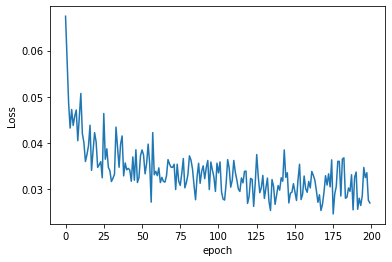

Iteration 2:


Training data samples: 15

Training loss:  0.049185287 



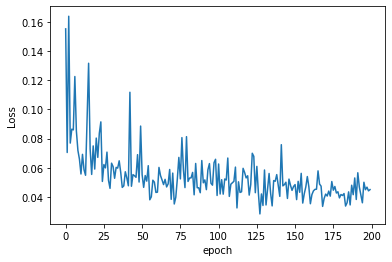

Iteration 3:


Training data samples: 10

Training loss:  0.04883402 



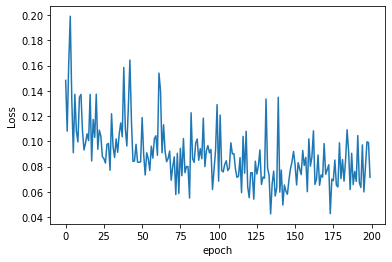

Iteration 4:


Training data samples: 39

Training loss:  0.0021140168 



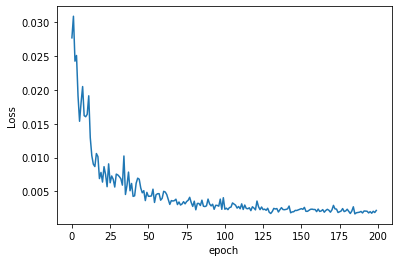

Iteration 5:


Training data samples: 6

Training loss:  0.0031544159 



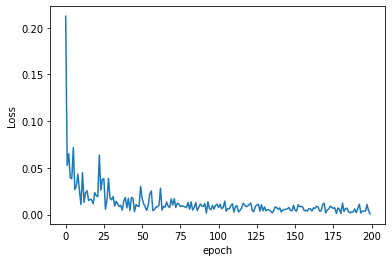

Evaluations...


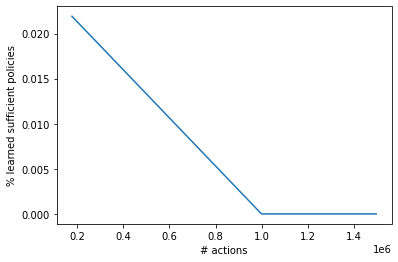

Iteration 6:


Training data samples: 9

Training loss:  0.019556025 



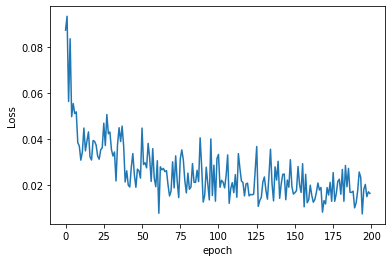

Iteration 7:


Training data samples: 35

Training loss:  0.006732 



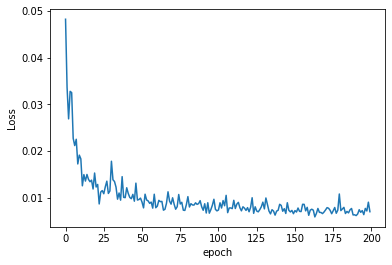

Iteration 8:


Training data samples: 8

Training loss:  0.014481562 



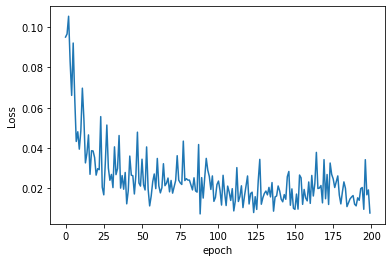

Iteration 9:


Training data samples: 13

Training loss:  0.027438898 



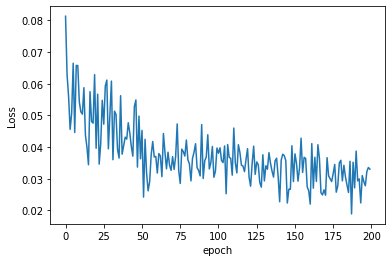

Iteration 10:


Training data samples: 10

Training loss:  0.08486684 



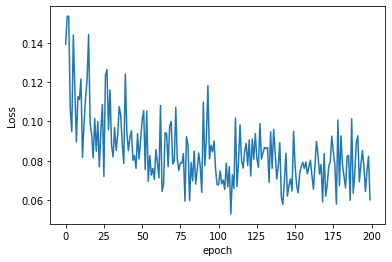

Evaluations...


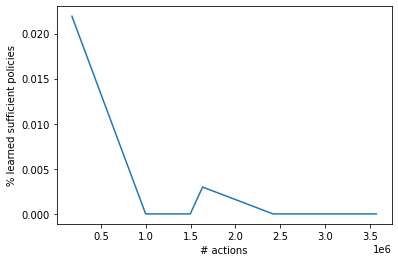

Iteration 11:


Training data samples: 41

Training loss:  0.0064709214 



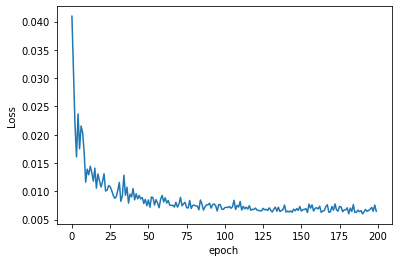

Iteration 12:


Training data samples: 9

Training loss:  0.08050609 



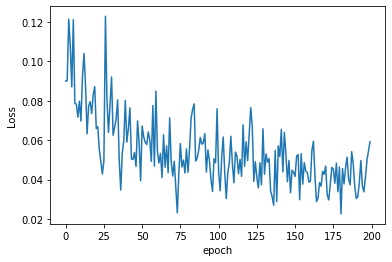

Iteration 13:


Training data samples: 41

Training loss:  0.007451211 



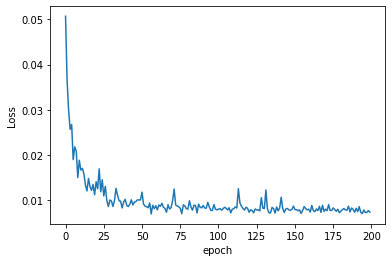

Iteration 14:


Training data samples: 7

Training loss:  0.017960565 



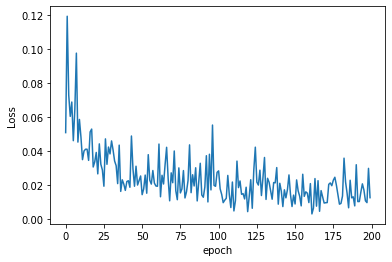

Iteration 15:


Training data samples: 17

Training loss:  0.011176264 



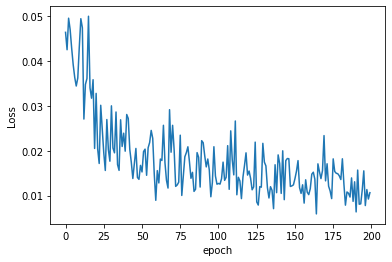

Evaluations...


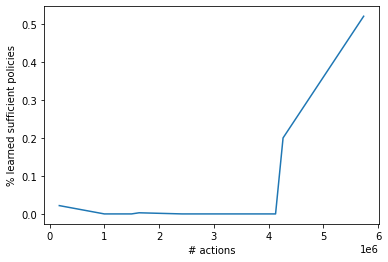

Iteration 16:


Training data samples: 29

Training loss:  0.033038538 



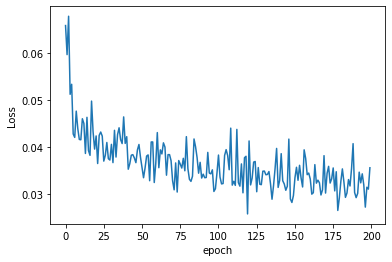

Iteration 17:


Training data samples: 7

Training loss:  0.046774883 



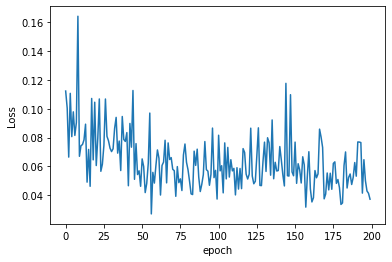

Iteration 18:


Training data samples: 14

Training loss:  0.0089602005 



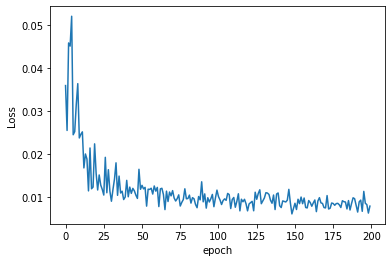

Iteration 19:


Training data samples: 6

Training loss:  0.01262775 



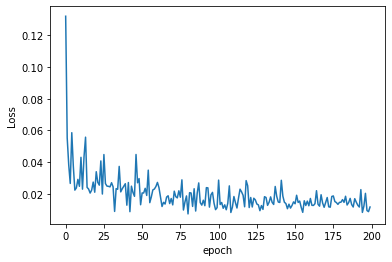

Iteration 20:


Training data samples: 8

Training loss:  0.030620933 



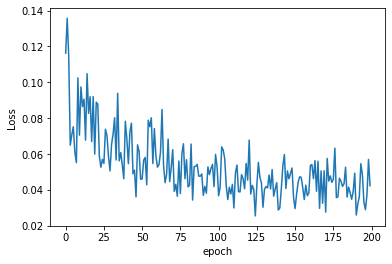

Evaluations...


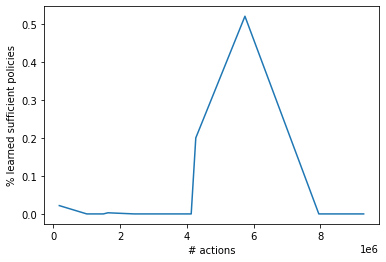

In [28]:
###################################################
### Preference-Based Policy Iteration Algorithm ###


### initializations ###

seed = 4 
model_name = 'cartPole_original' # name for the LabelRanker model

env = gym.make('CartPole_PbPI_Version-v0')   # environment
sample_states = generate_init_states_S(seed) # initial state list
max_iterr = 21 # max. num. of policy iterations

act_space = partition_action_space('CartPole_PbPI_Version-v0',3) # action space

act_pairs = list(itertools.combinations(act_space,2)) # generate action-pairs

policy = random_action # initial (random) policy

agg_pct_l_policies = [] # list to store the evaluation results, i.e., % of learned sufficient policies
action_count_li = []    # list to store the action counts in each training iteration

label_r_flag = False  # training loop configuration ('use-label-ranker' flag) 


print(f'\nNumber of initial states: {len(sample_states)}\n')
print(f'\nNumber of actions (per states): {len(act_space)}\n')


# track iteration progress
pbar = tqdm.notebook.tqdm(total=max_iterr, desc="Iteration", position = 0)

iterr = 1
while iterr < max_iterr:
    
    print(f'Iteration {iterr}:')
    
    train_data = []      # place-holder to store training data
    actions_in_iterr = 0 # variable to store the num. actions excuted in each iteration

    # track state loop progress
    pbar_states = tqdm.notebook.tqdm(total=len(sample_states), desc="States", position = 1, leave=False)
    
    for state in sample_states:
        
        for action_pair in act_pairs:
            
            preference_out, actions_per_pair = evaluate_preference(starting_state = state
                                                                 , action_1  = action_pair[0]
                                                                 , action_2  = action_pair[1]
                                                                 , policy_in = policy
                                                                 , label_ranker = label_r_flag
                                                                 , n_rollouts = 50
                                                                 , p_sig = 0.1)   
            
            if preference_out is not None:
                train_data.append(preference_out)
            else:
                pass
            
            # compute the number of actions executed in the iteration loop
            actions_in_iterr += actions_per_pair  
                    
        # update the state loop status
        pbar_states.update(1)
    
    # process training data and learn the LabelRanker model
    model = train_model(train_data
                        , act_space
                        , model_name = model_name
                        , mod_layers = [50]
                        , batch_s = 4
                        , n_epochs = 200
                        , l_rate = .1
                        , show_train_plot = True
                        )
    
    # when no traiing data is found -> no model returned 
    # - therefore, break the current iteration loop and continue to the next (after upadting iterr num. and action counts)
    if model is None:
        
        print(f'No training data collected!')
        pbar.update(1)
        
        # compute the cumulative number of actions across iterations
        if iterr>1:
            action_count_li.append(actions_in_iterr+action_count_li[iterr-2])
        else:
            action_count_li.append(actions_in_iterr)
            
        iterr += 1
        continue

        
    # derive a new policy using the trained model
    policy = Policy(act_space,model)
    
    # turn on the 'use-label-ranker' flag
    label_r_flag = True
    
    # compute the cumulative number of actions across iterations
    if iterr>1:
        action_count_li.append(actions_in_iterr+action_count_li[iterr-2])
    else:
        action_count_li.append(actions_in_iterr)
        
    # compute percent. of sufficient policies attained by the latest policy
    pct_succ_policies = run_evaluations(policy
                                        , sample_states
                                        , step_thresh=150) # steps needed for a sufficient policy
    agg_pct_l_policies.append(pct_succ_policies)
    
    # plot the 'num. actions' vs. 'pct. of sufficient policies'
    if iterr%5 == 0:
        print(f'Evaluations...')
        # clear the last plot data
        plt.clf()
        plt.cla()
        plt.close()

        # plotting rewards over iterations
        plt.plot(action_count_li, agg_pct_l_policies )
        plt.ylabel('% learned sufficient policies')
        plt.xlabel('# actions')
        plt.savefig(f'./train_imgs/{model_name}.png') # save the evaluation image
        plt.show()  
    
    # update the algorithm iteration status
    pbar.update(1)
    iterr += 1
        
pbar.close()

###################################################